In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import quantile_transform
# for hyperparemeter optimisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change the file names

meth = pd.read_csv('/content/drive/MyDrive/methy',delim_whitespace=True).transpose(copy = True)
mirna = pd.read_csv('/content/drive/MyDrive/mirna',delim_whitespace=True).transpose(copy = True)
exp = pd.read_csv('/content/drive/MyDrive/exp',delim_whitespace=True).transpose(copy = True)
surv = pd.read_csv('/content/drive/MyDrive/survival',delim_whitespace=True, index_col=0)
clinic = pd.read_csv('/content/drive/MyDrive/20150821-LIHC-Clinical.txt', index_col=0, sep='\t').transpose(copy = True)
#print(meth['cg00674365'])

#Exploratory Data Analysis

In [ ]:
#analysing clinical data
#clinic.head()

In [ ]:
#print(clinic.shape)

Removing unnecessary columns

In [4]:
#Checking null and unique counts of values in the columns of clinical data
null_counts = clinic.isnull().sum()
unique_counts = clinic.nunique()
# print("NULL COUNT:\n",null_counts)
# print("\nUNIQUE COUNT:\n",unique_counts)

In [5]:
clinic = clinic.drop(["Composite Element REF", "days_to_last_known_alive"], axis=1)
# clinic.head()

Joining clinical table and Survival table so as to retrieve similar IDs like rest of the datasets for the clinical data

In [6]:
#clinical table combined with Survival table
clinic = clinic.reset_index().rename(columns={'index': 'PatientID'})
surv = surv.reset_index().rename(columns={'PatientID': 'PatientID'})

def convert(id):
    new_id = id.lower() #lower case
    return new_id[:-3] #remving last three letters, "TCGA-2V-A9GS-01" becomes "tcga-2y-a9gs"

surv['PatientID_edit'] = surv['PatientID'].apply(convert)
clinical_Data = pd.merge(surv, clinic, left_on="PatientID_edit", right_on="PatientID", how="left")
clinical_Data.drop("PatientID_edit", axis=1, inplace=True)
clinical_Data.set_index('PatientID_x', inplace=True)
clinical_Data.rename(columns={'PatientID_y': 'PatientID'}, inplace=True)
# print(clinical_Data.head())
# print(clinical_Data.shape)

Visualizing data

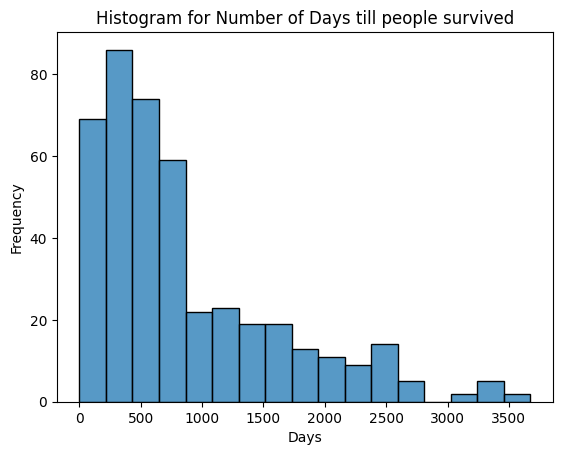

In [7]:
#Histogram for Number of Days till people survived
sns.histplot(data=clinical_Data['Survival'])

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram for Number of Days till people survived')

plt.show()

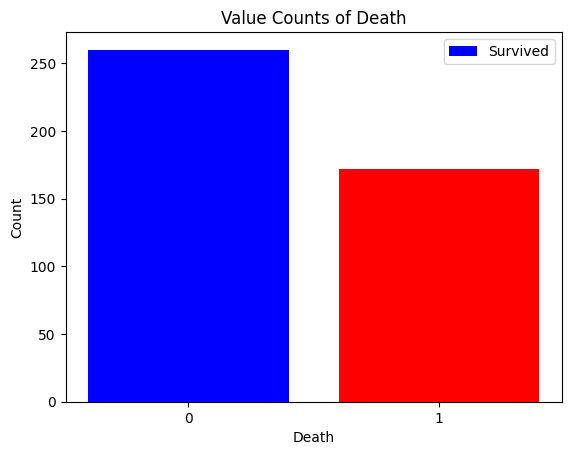

In [8]:
value_counts = clinical_Data["Death"].value_counts()

colors = ['blue', 'red']

plt.bar(value_counts.index, value_counts.values, color=colors)

plt.xticks([0, 1])

plt.xlabel("Death")
plt.ylabel("Count")
plt.title("Value Counts of Death")

legend_labels = ["Survived", "Deceased"]
plt.legend(legend_labels)
plt.show()


In [9]:
grouped_data = clinical_Data.groupby(['Death', 'gender']).size().unstack()
print(grouped_data)


gender  female  male
Death               
0.0         73   180
1.0         67   105


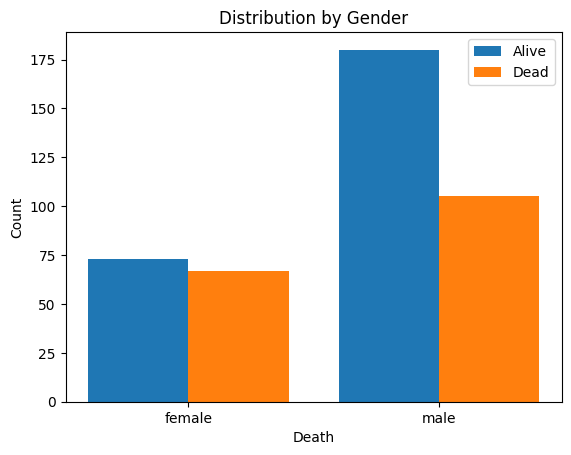

In [10]:
survived_data = (grouped_data.loc[0.0].values).tolist()
diceased_data = (grouped_data.loc[1.0].values).tolist()

x = np.arange(len(diceased_data))
width = 0.4

plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, diceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by Gender')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

In [11]:
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()
print(grouped_data)

pathologic_stage  stage i  stage ii  stage iii  stage iiia  stage iiib  \
Death                                                                    
0.0                 137.0      63.0        2.0        30.0         5.0   
1.0                  57.0      35.0        4.0        40.0         4.0   

pathologic_stage  stage iiic  stage iv  stage iva  stage ivb  
Death                                                         
0.0                      4.0       NaN        1.0        NaN  
1.0                      6.0       3.0        NaN        2.0  


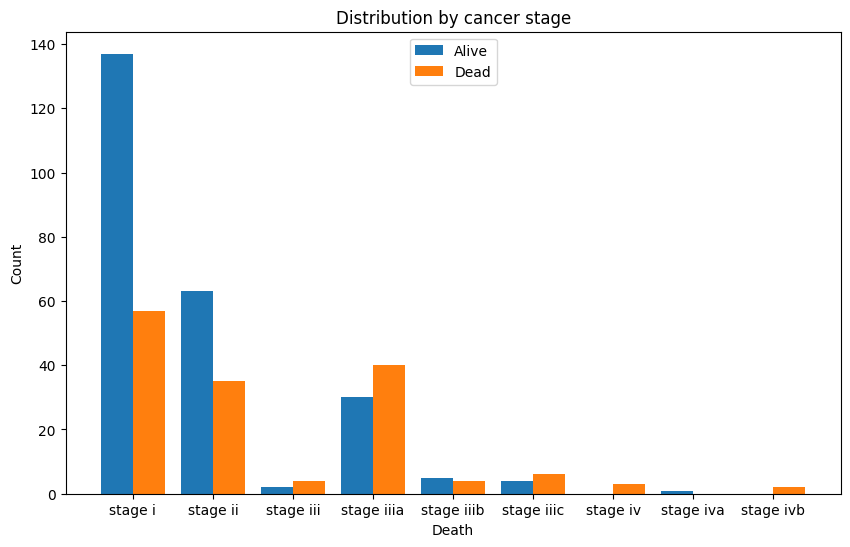

In [12]:
survived_data = grouped_data.loc[0.0].values.tolist()
deceased_data = grouped_data.loc[1.0].values.tolist()

x = np.arange(len(deceased_data))
width = 0.4

fig = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, deceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by cancer stage')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

Most of the data is available for stage i and stage ii cancer. This is the reason why most of the data is available for class 0(surviving).

In [13]:
grouped_data = grouped_data.fillna(0)
grouped_data

pathologic_stage,stage i,stage ii,stage iii,stage iiia,stage iiib,stage iiic,stage iv,stage iva,stage ivb
Death,,,,,,,,,
0.0,137.0,63.0,2.0,30.0,5.0,4.0,0.0,1.0,0.0
1.0,57.0,35.0,4.0,40.0,4.0,6.0,3.0,0.0,2.0


In [14]:
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()

#print("......................................................")
filtered_data = clinical_Data[(clinical_Data['pathologic_stage'] == 'stage i') & (clinical_Data['Death'] == 0)]
filtered_data1 = clinical_Data[(clinical_Data['pathologic_stage'] == 'stage ii') & (clinical_Data['Death'] == 0)]
#print(filtered_data)
#print(".......................................................")
reduced_data = filtered_data.sample(n=57, random_state=42)
reduced_data1 = filtered_data1.sample(n=35, random_state=42)
# Update the clinical_Data DataFrame with the reduced samples
clinical_Data = clinical_Data.drop(filtered_data.index)  # Remove the filtered samples
clinical_Data = pd.concat([clinical_Data, reduced_data])  # Add the reduced samples back to the DataFrame
clinical_Data = clinical_Data.drop(filtered_data1.index)  # Remove the filtered samples
clinical_Data = pd.concat([clinical_Data, reduced_data1])  # Add the reduced samples back to the DataFrame
clinical_Data['pathologic_stage'] = clinical_Data['pathologic_stage'].replace(['stage iii','stage iiia', 'stage iiib', 'stage iiic'], 'stage iii')
clinical_Data['pathologic_stage'] = clinical_Data['pathologic_stage'].replace(['stage iv','stage iva', 'stage ivb'], 'stage iv')
#print(clinical_Data)
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()
#print(grouped_data)

Samples for Tumor type i and ii are balanced. stage iii and stage iv data are merged

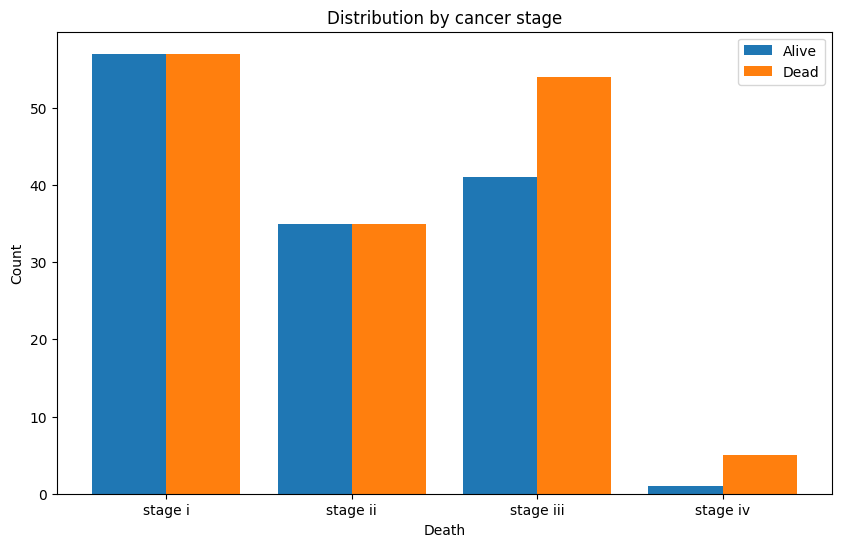

In [15]:
survived_data = grouped_data.loc[0.0].values.tolist()
deceased_data = grouped_data.loc[1.0].values.tolist()

x = np.arange(len(deceased_data))
width = 0.4

fig = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, deceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by cancer stage')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

gender  female  male
Death               
0.0         47    98
1.0         67   105


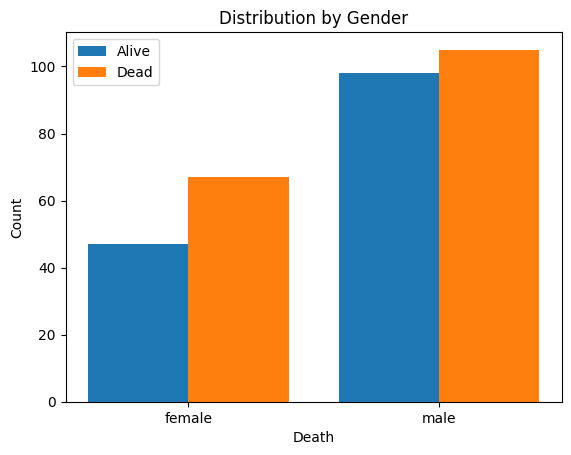

In [16]:
grouped_data = clinical_Data.groupby(['Death', 'gender']).size().unstack()
print(grouped_data)

survived_data = (grouped_data.loc[0.0].values).tolist()
diceased_data = (grouped_data.loc[1.0].values).tolist()

x = np.arange(len(diceased_data))
width = 0.4

plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, diceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by Gender')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

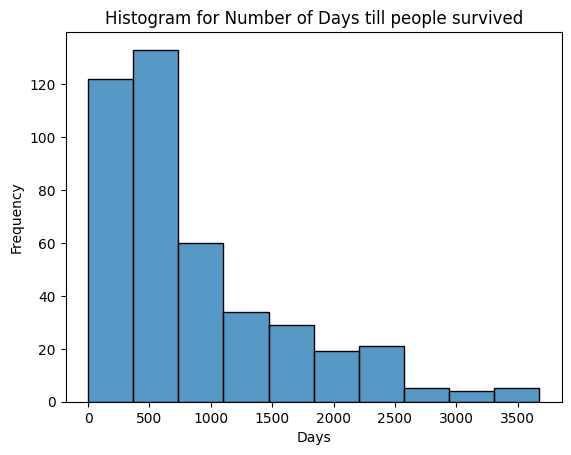

In [17]:
# Create the histogram using seaborn
sns.histplot(data=surv['Survival'], bins=10)  # Adjust the number of bins as per your requirement

# Set labels and title
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram for Number of Days till people survived')

# Display the histogram
plt.show()

DATA FOR DIFFERENTIALLY EXPRESSED GENES ANALYSIS

In [18]:
print(clinical_Data.shape)
clinical_Data.to_csv('clinical_Data.csv', index=True)

(330, 19)


In [19]:
meth_diff = pd.read_csv('/content/drive/MyDrive/new_up/Diff_methylupdated.csv', index_col=0).transpose(copy = True)
mirna_diff = pd.read_csv('/content/drive/MyDrive/new_up/Diff_mirnaupdated.csv', index_col=0).transpose(copy = True)
exp_diff = pd.read_csv('/content/drive/MyDrive/new_up/Diff_mrnaupdated.csv', index_col=0).transpose(copy = True)
#print(meth_diff)
# Exclude the first column from the conversion
m_values = meth_diff.iloc[:,:]

# Apply the conversion formula to each M value
beta_values = np.exp2(m_values) / (np.exp2(m_values) + 1)

# Insert the first column back into the resulting DataFrame
beta_df = pd.concat([beta_values], axis=1)
meth_diff=beta_df


In [20]:
# print(meth_diff.shape)
# print(mirna_diff.shape)
# print(exp_diff.shape)


meth1=meth_diff.copy()
mirna1=mirna_diff.copy()
exp1=exp_diff.copy()
#exp1
# print(meth1)
#print(mirna1)
# print(exp1)

In [21]:
meth1.reset_index(inplace=True)
meth1.rename(columns={'index': 'PatientID'}, inplace=True)
meth1['PatientID'] = meth1['PatientID'].str.replace('.', '-', regex=False)
#meth1

meth1 = pd.merge(clinical_Data['Death'], meth1, left_on='PatientID_x', right_on='PatientID')
meth1 = meth1.dropna(subset=['Death'])
meth1.set_index(meth1.columns[1], inplace=True)
#print(meth1)

In [22]:
mirna1.reset_index(inplace=True)
mirna1.rename(columns={'index': 'PatientID'}, inplace=True)
mirna1['PatientID'] = mirna1['PatientID'].str.replace('.', '-', regex=False)
#mirna1

mirna1 = pd.merge(clinical_Data['Death'], mirna1, left_on='PatientID_x', right_on='PatientID')
mirna1 = mirna1.dropna(subset=['Death'])
mirna1.set_index(mirna1.columns[1], inplace=True)
#print(mirna1)

In [23]:
exp1.reset_index(inplace=True)
exp1.rename(columns={'index': 'PatientID'}, inplace=True)
exp1['PatientID'] = exp1['PatientID'].str.replace('.', '-', regex=False)
#exp1

exp1 = pd.merge(clinical_Data['Death'], exp1, left_on='PatientID_x', right_on='PatientID')
exp1 = exp1.dropna(subset=['Death'])
exp1.set_index(exp1.columns[1], inplace=True)
#print(exp1)

In [24]:
from google.colab import files
# meth1.to_csv('methforq.csv', index=True)

# # Download the CSV file
# files.download('methforq.csv')
# mirna1.to_csv('mirnaforq.csv', index=True)

# # Download the CSV file
# files.download('mirnaforq.csv')
# exp1.to_csv('expforq.csv', index=True)

# # Download the CSV file
# files.download('expforq.csv')

In [25]:
# Apply quantile normalization using the 'quantile_transform' function
meth1.iloc[:, 1:] = quantile_transform(meth1.iloc[:, 1:], copy=True)
transformer = QuantileTransformer(output_distribution="normal").fit(meth1.iloc[:, 1:])
scale_meth = pd.DataFrame(transformer.transform(meth1.iloc[:, 1:]))
scale_meth.columns = meth1.iloc[:, 1:].columns
scale_meth.index = meth1.index
#meth = meth1

#Log2 transformation
mirna1.iloc[:, 1:] = np.log2(mirna1.iloc[:, 1:]+1)
scaler = StandardScaler().fit(mirna1.iloc[:, 1:])
scale_mirna = pd.DataFrame(scaler.transform(mirna1.iloc[:, 1:]))
scale_mirna.columns = mirna1.iloc[:, 1:].columns
scale_mirna.index = mirna1.index

#Log2 transformation and scaling for
exp1.iloc[:,1:] = np.log2(exp1.iloc[:,1:]+1)
scaler = StandardScaler().fit(exp1.iloc[:,1:])
scale_exp = pd.DataFrame(scaler.transform(exp1.iloc[:,1:]))
scale_exp.columns = exp1.iloc[:, 1:].columns
scale_exp.index = exp1.index

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (299). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (299). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
#print(meth1)
# print(mirna1)
# print(exp1)

#Scaling the data
#scale_meth

In [26]:
concat_data = pd.concat([scale_meth, scale_mirna, scale_exp], axis=1)
concat_data.shape

(299, 209)

In [ ]:
#concat_data.head()

In [27]:
concat_data.reset_index(inplace=True)
concat_data.rename(columns={'index': 'PatientID'}, inplace=True)
concat_data['PatientID'] = concat_data['PatientID'].str.replace('.', '-', regex=False)
#concat_data

In [ ]:
#clinical_Data["Death"]

In [30]:
concat_R = pd.merge(clinical_Data['Death'], concat_data, left_on='PatientID_x', right_on='PatientID')
concat_R = concat_R.dropna(subset=['Death'])
concat_R.set_index(concat_R.columns[1], inplace=True)
#print(concat_R)

In [ ]:
#concat_R

In [31]:
print(concat_R["Death"].value_counts())
LG = concat_R.iloc[:, 1:]
y = concat_R["Death"]
y=LabelEncoder().fit_transform(y)
LG.shape,y.shape

1.0    155
0.0    144
Name: Death, dtype: int64


((299, 209), (299,))

# Classifier


**Gradient Boost**

In [32]:


X_train,X_test,Y_train,Y_test=train_test_split(LG, y,
                                                test_size=0.33,
                                                train_size =  0.67,
                                                stratify=y,
                                                random_state=50)

X_test.shape
combined_data = np.hstack((X_train, Y_train.reshape(-1, 1)))  # Stack arrays horizontally
concatenated_df = pd.DataFrame(combined_data, columns=LG.columns.tolist() + ['Death'])  # Convert to DataFrame
#concatenated_df

In [33]:
aug_x=concatenated_df
aug_x_0 = aug_x[aug_x['Death'] == 0]
aug_x_1 = aug_x[aug_x['Death'] == 1]
aug_x_1=aug_x_1.iloc[:,0:209]
aug_x_0=aug_x_0.iloc[:,0:209]
#aug_x_1

In [34]:
scaler = StandardScaler()

# Fit the scaler on the original data
scaler.fit(aug_x_0)

# Define the desired number of augmented rows
desired_rows = 600

# Generate augmented data
augmented_data = scaler.inverse_transform(
    np.random.randn(desired_rows - len(aug_x_0), aug_x_0.shape[1]))

# Convert the augmented data to a DataFrame
augmented_X_0 = pd.DataFrame(augmented_data, columns=aug_x_0.columns)

# Concatenate the augmented data with the original data
augmented_X_0 = pd.concat([aug_x_0, augmented_X_0], ignore_index=True)

augmented_X_0['Death']=0

#augmented_X_0

In [35]:
scaler = StandardScaler()

# Fit the scaler on the original data
scaler.fit(aug_x_1)

# Define the desired number of augmented rows
desired_rows = 600

# Generate augmented data
augmented_data = scaler.inverse_transform(
    np.random.randn(desired_rows - len(aug_x_1), aug_x_1.shape[1]))

# Convert the augmented data to a DataFrame
augmented_X_1 = pd.DataFrame(augmented_data, columns=aug_x_1.columns)

# Concatenate the augmented data with the original data
augmented_X_1 = pd.concat([aug_x_1, augmented_X_1], ignore_index=True)

augmented_X_1['Death']=1

#augmented_X_1

In [36]:
sub_array=pd.concat([augmented_X_0,augmented_X_1],axis=0)
sub_array
X_train = sub_array.drop("Death", axis=1)
Y_train = sub_array[["Death"]].copy()
X_train=np.array(X_train)
Y_train=np.array(Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 5
AUC score: 0.5998774509803921
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 100
AUC score: 0.7369281045751633
---------------------------------------------------------
Number of estimators: 25
AUC score: 0.6801470588235294
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 75
AUC score: 0.7250816993464052
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 170
AUC score: 0.7728758169934641
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 200
AUC score: 0.7781862745098039
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 180
AUC score: 0.7720588235294118
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 1000
AUC score: 0.7642973856209151
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 2000
AUC score: 0.7585784313725491
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of estimators: 1500
AUC score: 0.7577614379084967
---------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Number of estimators: 5000
AUC score: 0.7573529411764706
---------------------------------------------------------


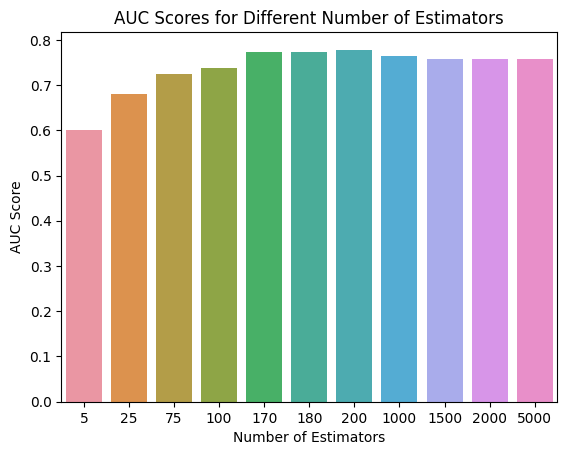

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

n_estimators_list = [5,100,25,75,170,200,180,1000,2000,1500,5000]
auc_scores = []
for n_estimators in n_estimators_list:
    # Initialize the AdaBoost Classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators,max_features=3, random_state=10) #THIS ONE TAKES A LOOOOOOT OF TIME

    # Fit the classifier on the training data
    gb_classifier.fit(X_train, Y_train)

    # Predict probabilities on the test data
    probs = gb_classifier.predict_proba(X_test)

    # Extract the probabilities of the positive class
    positive_class_probs = probs[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(Y_test, positive_class_probs)
    auc_scores.append(auc_score)

    print('Number of estimators:', n_estimators)
    print('AUC score:', auc_score)
    print('---------------------------------------------------------')
# n_estimators_list = [50, 25, 50, 75, 100, 15, 10]
# auc_scores = []

# for est in n_estimators_list:
#     # Initialize the Gradient Boosting Classifier
#     gb_classifier = GradientBoostingClassifier(n_estimators=est, max_features=8, random_state=14)

#     # Fit the classifier on the training data
#     gb_classifier.fit(X_train, Y_train)

#     # Predict probabilities on the test data
#     probs = gb_classifier.predict_proba(X_test)

#     # Extract the probabilities of the positive class
#     positive_class_probs = probs[:, 1]

#     # Calculate the AUC score
#     auc_score = roc_auc_score(Y_test, positive_class_probs)
#     auc_scores.append(auc_score)

#     print('Number of estimators:', est)
#     print('AUC score:', auc_score)
#     print('---------------------------------------------------------')

# Plotting the bar graph using Seaborn
sns.barplot(x=n_estimators_list, y=auc_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Number of Estimators')
plt.show()


In [38]:
# gb_est = GradientBoostingClassifier(n_estimators=75, max_features=8, random_state=1)
# kfold = KFold(n_splits=10, shuffle=True, random_state=0)

gb_est = GradientBoostingClassifier(n_estimators=5000,max_features=3, random_state=10)
gb_est.fit(X_train, Y_train)
kfold = KFold(n_splits=25, shuffle=True, random_state=0)
probabilities_train = cross_val_predict(gb_est, X_train, Y_train.ravel(), cv=kfold, method='predict_proba')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For training data

In [39]:
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]

In [40]:
cm_test = confusion_matrix(Y_train, Y_pred_train)
cm_test

array([[574,  26],
       [ 31, 569]])

In [41]:
# GB CLASSIFIER
# Fit the classifier on the training data
# probabilities_train = cross_val_predict(gb_est, X_train, Y_train.ravel(), cv=kfold, method='predict_proba')
# Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]


# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_train, Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.953
Precision : 0.956
Recall : 0.948
F1-score : 0.952
Sensitivity (Recall): 0.9483333333333334
Specificity (True Negative Rate): 0.9566666666666667


For test data

In [42]:
gbt=gb_est.fit(X_train, Y_train)
test_pro=gbt.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [43]:
test_pro
Y_pred_test = [0 if p[0] > 0.5 else 1 for p in test_pro]
print(Y_pred_test)
print(">>>>>>>>>>>>>>>>>>>>>>>>>")
print(Y_test)

[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
>>>>>>>>>>>>>>>>>>>>>>>>>
[1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0
 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0
 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1]


In [44]:
cm_test = confusion_matrix(Y_test, Y_pred_test)
cm_test

array([[31, 17],
       [19, 32]])

In [45]:
# Calculate scores
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
#recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_test, Y_pred_test)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
#print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.636
Precision : 0.653
F1-score : 0.640
Sensitivity (Recall): 0.6274509803921569
Specificity (True Negative Rate): 0.6458333333333334


In [46]:
#WITHOUT CROSS VAL
# Fit the classifier on the training data
gb_est.fit(X_train, Y_train)

# Predict probabilities on the test data
probs = gb_est.predict_proba(X_test)

Y_pred_test = [0 if p[0] > 0.5 else 1 for p in probs]


# Calculate scores
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
recall = recall_score(Y_test, Y_pred_test)
f1 = f1_score(Y_test, Y_pred_test)
positive_class_probs = probs[:, 1]
auc= roc_auc_score(Y_test, positive_class_probs)

# Print the scores
print("For testing data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("ROC: %.3f" % auc)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For testing data:
Accuracy : 0.636
Precision : 0.653
Recall : 0.627
F1-score : 0.640
ROC: 0.757


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


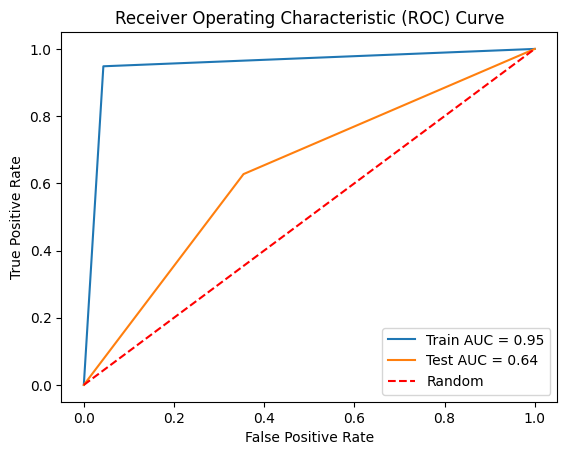

In [50]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, Y_pred_train)
auc_train = roc_auc_score(Y_train, Y_pred_train)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, Y_pred_test)
auc_test = roc_auc_score(Y_test, Y_pred_test)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [52]:
#SVM
# Define the SVM classifier
random_state = 50
svm_classifier = svm.SVC(random_state=random_state)
#svm_classifier = svm.SVC()


# C_range_rbf = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
# gamma_range_rbf = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
#param_dict_rbf = dict(gamma=gamma_range_rbf, C=C_range_rbf, kernel='rbf')

# Define the hyperparameters to tune
parameters = {
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9],
    'gamma': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'kernel': ['rbf', 'poly']
}

grid_search=GridSearchCV(estimator=svm_classifier,param_grid=parameters,cv=10)
grid_search.fit(X_train,Y_train)

y_train_pred = grid_search.predict(X_train)

# Step 3: Calculate confusion matrix
cm = confusion_matrix(Y_train, y_train_pred)
print("Confusion Matrix:")
print(cm)





/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Confusion Matrix:
[[600   0]
 [  0 600]]


In [53]:
# Calculate scores
accuracy = accuracy_score(Y_train, y_train_pred)
precision = precision_score(Y_train, y_train_pred)
recall = recall_score(Y_train, y_train_pred)
f1 = f1_score(Y_train, y_train_pred)
auc_score = roc_auc_score(Y_train, y_train_pred)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("AUC : %.3f"% auc_score)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000
AUC : 1.000
Sensitivity (Recall): 1.0
Specificity (True Negative Rate): 1.0


In [54]:
# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Evaluate the model with the best hyperparameters on the test set
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on test set: ", accuracy)

Best hyperparameters:  {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Best accuracy:  0.9208333333333334
Accuracy on test set:  0.6565656565656566


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [55]:
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[30 18]
 [16 35]]


In [56]:
# Calculate scores
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
auc_score = roc_auc_score(Y_test, y_pred)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("AUC %.3f"% auc_score)
# Calculate sensitivity (also known as recall or true positive rate)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# Calculate specificity (also known as true negative rate)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity (Recall):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

For training data:
Accuracy : 0.657
Precision : 0.660
Recall : 0.686
F1-score : 0.673
AUC 0.656
Sensitivity (Recall): 0.6862745098039216
Specificity (True Negative Rate): 0.625


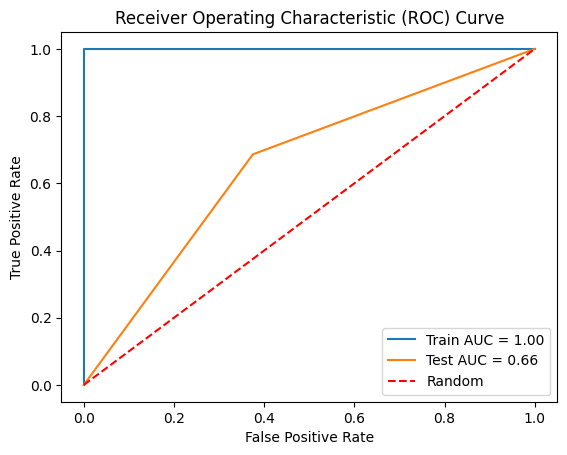

In [57]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, y_train_pred)
auc_train = roc_auc_score(Y_train, y_train_pred)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, y_pred)
auc_test = roc_auc_score(Y_test, y_pred)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

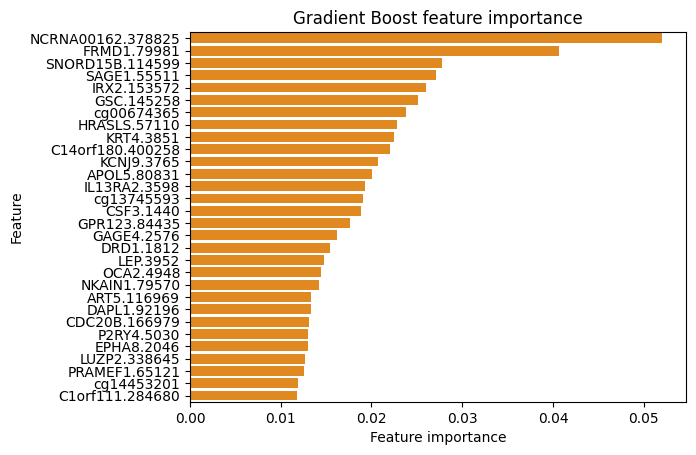

In [58]:
feature_import = pd.DataFrame([LG.columns,gb_est.feature_importances_]).T
feature_import.columns = ['feature', 'importance']
feature_import.sort_values('importance', ascending=False, inplace=True)
sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Gradient Boost feature importance')
feature_import
# Download the CSV file
feature_import.to_csv('feature_import.csv', index=True)
files.download('feature_import.csv')
# feature_import.head(18)

Survival Analysis

In [ ]:
from google.colab import files

In [ ]:
filtered_features = feature_import[feature_import.iloc[:, 1] > 0.010]
filtered_features.shape

(28, 2)

In [ ]:
filt_cols = LG[filtered_features.iloc[:, 0].tolist()]
filt_cols

,NCRNA00162.378825,KRTAP1.1.81851,FRMD1.79981,EPO.2056,SAGE1.55511,KLK3.354,SNORD15B.114599,CLSTN2.64084,C14orf180.400258,CEACAM5.1048,...,IL13RA2.3598,STMN4.81551,CSF3.1440,MARCO.8685,IRX2.153572,HRASLS.57110,LUZP2.338645,C21orf62.56245,OCA2.4948,KRT4.3851
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9GS-01,-0.234464,0.105272,-0.695263,-1.272244,-0.345803,-0.365158,-0.496575,-0.431427,-0.563255,-0.582596,...,-0.339463,-0.480800,-0.606532,0.272544,0.353652,0.178078,-0.778122,0.680448,0.009293,-0.450483
TCGA-2Y-A9GT-01,-0.234464,-0.481858,-1.015320,-0.150990,-0.345803,-0.365158,-0.496575,0.011654,-0.797923,-0.582596,...,-0.321748,-0.480800,-0.606532,-0.858502,-0.655702,0.640838,-0.778122,-0.177866,-0.934538,-0.450483
TCGA-2Y-A9GV-01,-0.234464,-0.481858,-1.015320,-0.042265,-0.345803,-0.365158,-0.496575,-0.523129,-0.797923,-0.132719,...,-0.855021,-0.480800,0.792627,-0.446641,0.246312,-0.752141,0.237634,-0.205136,0.337392,-0.450483
TCGA-2Y-A9GW-01,0.620636,-0.481858,-1.015320,0.926472,-0.345803,-0.365158,-0.496575,-0.034770,-0.098939,-0.582596,...,-0.392471,0.559238,-0.606532,1.143012,-0.655702,0.507974,0.705693,0.113138,0.742109,-0.450483
TCGA-2Y-A9GY-01,-0.234464,-0.481858,-0.100791,1.531977,0.533546,-0.365158,-0.496575,-0.780683,-0.797923,0.560769,...,1.293579,-0.480800,-0.000516,1.364878,-0.655702,0.547185,-0.277710,0.745962,-0.165268,0.503810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,0.379297,-0.481858,0.868896,-0.617605,0.028938,-0.365158,0.326009,0.345171,-0.797923,0.439462,...,0.450586,0.265704,-0.606532,-1.107715,-0.054879,-0.198424,-0.778122,-0.411155,2.305199,-0.450483
TCGA-WX-AA46-01,-0.234464,0.207334,-0.037324,-0.901373,-0.345803,-0.365158,-0.496575,1.149488,0.908147,-0.582596,...,1.101549,-0.480800,1.123520,1.022336,0.505255,-0.752141,-0.778122,-0.028014,-0.934538,-0.450483
TCGA-ZS-A9CE-01,-0.234464,-0.481858,0.927985,-0.815733,-0.345803,-0.365158,1.459916,-0.885261,-0.365081,-0.582596,...,-0.171881,0.870464,-0.606532,-0.097107,2.610597,-0.752141,-0.110660,-0.822128,-0.360894,-0.450483


In [ ]:
surv_Data = pd.merge(filt_cols, clinical_Data, left_index=True, right_index=True, how="left")
surv_Data = surv_Data.drop(['PatientID','tumor_tissue_site'], axis=1)
clinical_Data

,Survival,Death,PatientID,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
PatientID_x,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2Y-A9GS-01,724.0,1.0,tcga-2y-a9gs,58,1,724,NaN,liver,stage iv,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
TCGA-2Y-A9GT-01,1624.0,1.0,tcga-2y-a9gt,51,1,1624,NaN,liver,stage i,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GV-01,2532.0,1.0,tcga-2y-a9gv,54,1,2532,NaN,liver,stage i,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GW-01,1271.0,1.0,tcga-2y-a9gw,64,1,1271,NaN,liver,stage i,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WX-AA46-01,756.0,0.0,tcga-wx-aa46,61,0,NaN,756,liver,stage ii,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-ZS-A9CE-01,1241.0,0.0,tcga-zs-a9ce,79,0,NaN,1241,liver,stage ii,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-DD-A4NJ-01,928.0,0.0,tcga-dd-a4nj,54,0,NaN,928,liver,stage ii,t2,n0,m0,female,2011,no,hepatocellular carcinoma,r0,white,not hispanic or latino


In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 8.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1dd444347ba3599f0d9087f047d8ec55082fdb1165f5c7b5685d71888e70aad2
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter



In [ ]:
cph = CoxPHFitter()
cph.fit(sample_data, duration_col='Survival', event_col='Death')
cph.print_summary()
cph.plot()

KeyError: ignored

In [ ]:
surv_Data['Survival']

0       724.0
1      1624.0
2      2532.0
3      1271.0
4       757.0
        ...  
294     854.0
295     756.0
296    1241.0
297    1570.0
298    2455.0
Name: Survival, Length: 299, dtype: float64

In [ ]:
surv_Data

,cg12036633,cg14453201,MYH1.4619,cg00674365,cg02767633,cg14619259,MYH3.4621,cg15415945,MSC.9242,LUZP2.338645,...,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9GS-01,-3.934869,-0.372569,6.4071,-3.700242,-1.648986,0.920798,31.0498,2.694297,1887.8068,0.0000,...,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
TCGA-2Y-A9GT-01,-4.195665,1.319381,0.0000,1.114395,-0.859163,0.338144,45.7297,5.397047,86.0794,0.0000,...,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GV-01,-0.121801,-3.069196,0.0000,-0.190199,-0.602283,-0.790024,57.5296,0.250047,23.6887,3.3841,...,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GW-01,-0.235417,-0.249125,0.0000,-0.257036,-1.016317,0.068506,29.1188,4.009919,2699.3257,7.6628,...,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GY-01,-4.195968,-4.440740,2.1425,-5.291615,-1.502893,-4.637505,25.1741,4.413314,642.5495,1.0712,...,t2,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,-0.291647,-1.094005,2.0171,-0.087371,3.317134,-2.504322,54.4629,0.169481,918.6737,0.0000,...,t2,n0,m0,female,2012,no,hepatocellular carcinoma,r0,asian,not hispanic or latino
TCGA-WX-AA46-01,-0.213592,-4.412207,0.0000,-5.310673,2.369393,-0.209207,62.4625,5.760275,25.2252,0.0000,...,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-ZS-A9CE-01,-0.210789,1.920194,0.0000,1.621164,-4.516270,-1.180263,38.2932,-0.773562,22.9759,1.6411,...,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white,not hispanic or latino
